In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [16]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer

2024-07-09 13:41:53.412836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 13:41:53.412958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 13:41:53.556438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding='latin-1')

In [4]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [5]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [6]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [7]:
df.shape

(5572, 2)

In [8]:
df.rename(columns={'v1':'class','v2':'sms'},inplace=True)
df.sample(5)

,class,sms
4929,spam,"Hi, the SEXYCHAT girls are waiting for you to ..."
1882,ham,"Sorry, I can't help you on this."
3219,ham,Its like that hotel dusk game i think. You sol...
4705,ham,Wow so healthy. Old airport rd lor. Cant thk o...
4202,ham,C movie is juz last minute decision mah. Juz w...


In [9]:
df['class'].value_counts()

class
ham     4825
spam     747
Name: count, dtype: int64

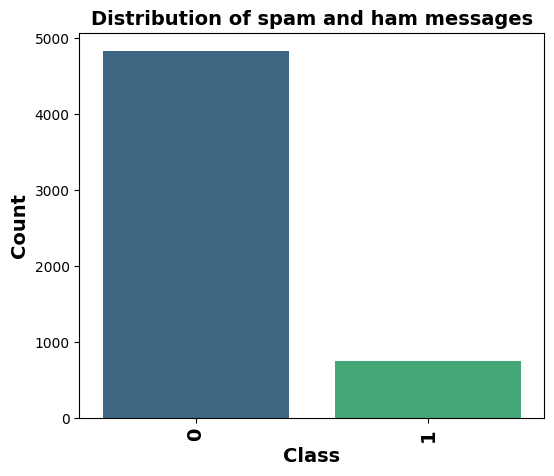

In [13]:
plt.figure(figsize=(6, 5))
counts=df['class'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='viridis')
plt.xlabel('Class', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of spam and ham messages', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['class'] = encoder.fit_transform(df['class'])
df.head(5)

,class,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [69]:
import re  # used for pattern matching and text manipulation.
import string 
import nltk #a powerful library for working with human language data.
from nltk.corpus import stopwords #for cleaning 
from nltk.stem import LancasterStemmer
from wordcloud import WordCloud, STOPWORDS

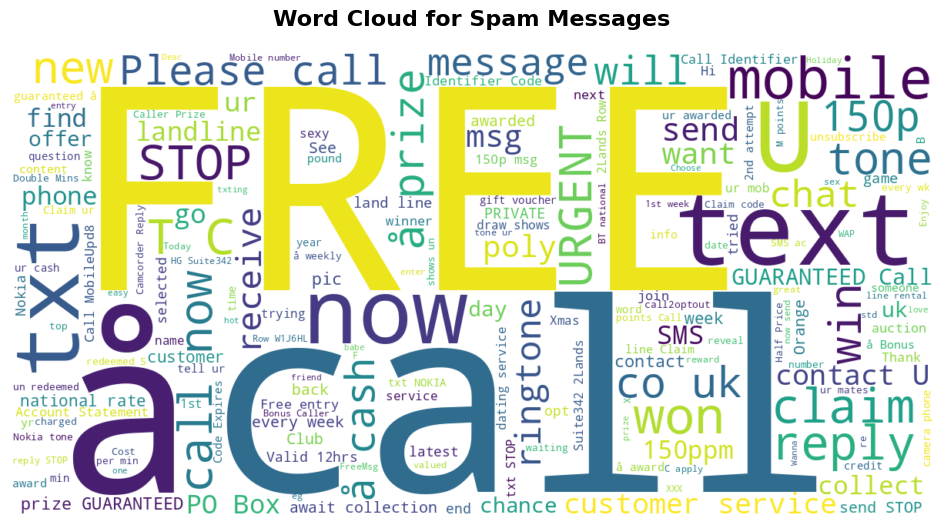

In [78]:
wc = WordCloud(width=1200, height=600, min_font_size=10, background_color='white')
spam_wc = wc.generate(df[df['class'] == 1]['sms'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.title('Word Cloud for Spam Messages', fontsize=16, fontweight='bold', pad=20)
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

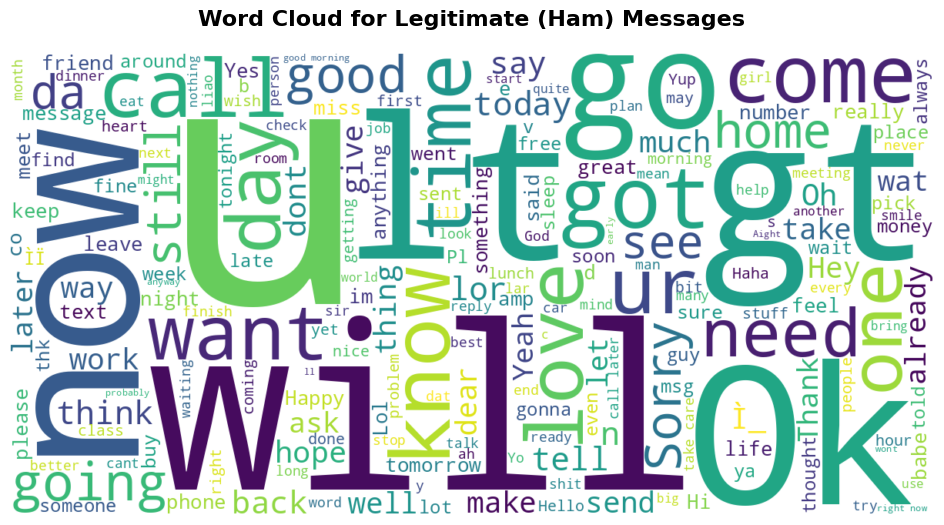

In [79]:
ham_wc = wc.generate(df[df['class'] == 0]['sms'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.title('Word Cloud for Legitimate (Ham) Messages', fontsize=16, fontweight='bold', pad=20)
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [96]:
x,y=np.array(df['sms']),np.array(df['class'])

In [97]:
x

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       ..., 'Pity, * was in mood for that. So...any other suggestions?',
       "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free",
       'Rofl. Its true to its name'], dtype=object)

In [98]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2, random_state=51)

In [19]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4457,), (1115,), (4457,), (1115,))

In [99]:
tfidf = TfidfVectorizer()
X_tfidf_train = tfidf.fit_transform(X_train)
X_tfidf_test = tfidf.transform(X_test)

In [37]:
X_tfidf_train

<4457x6554 sparse matrix of type '<class 'numpy.float64'>'
	with 33431 stored elements in Compressed Sparse Row format>

In [104]:
from sklearn.metrics import accuracy_score,classification_report

In [100]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_tfidf_train, Y_train)

# Make predictions on the validation set
y_pred_lr = classifier.predict(X_tfidf_test)

# Evaluate the performance of the model
accuracy = accuracy_score(Y_test, y_pred_lr)
print("test Accuracy using logistic regression:", accuracy)



test Accuracy using logistic regression: 0.9713004484304932


In [101]:
from sklearn.svm import SVC
model_svc = SVC()
model_svc.fit(X_tfidf_train, Y_train)
y_pred_svc = model_svc.predict(X_tfidf_test)

# Evaluate the performance of the model
accuracy_svc = accuracy_score(Y_test, y_pred_svc)
print("test Accuracy using svm:", accuracy_svc)


test Accuracy using svm: 0.9820627802690582


In [102]:
from sklearn.naive_bayes import MultinomialNB
nb_classifier=MultinomialNB()
nb_classifier.fit(X_tfidf_train, Y_train)
y_pred_nb = nb_classifier.predict(X_tfidf_test)

# Evaluate the performance of the model
accuracy_nb = accuracy_score(Y_test, y_pred_nb)
print(" Accuracy of multinomialNB :", accuracy_nb)

 Accuracy of multinomialNB : 0.95695067264574


In [107]:

print(classification_report(Y_test, y_pred_svc))
print("Confusion Matrix")
cm=confusion_matrix(Y_test, y_pred_svc)
print(cm)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       962
           1       0.99      0.88      0.93       153

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix
[[961   1]
 [ 19 134]]


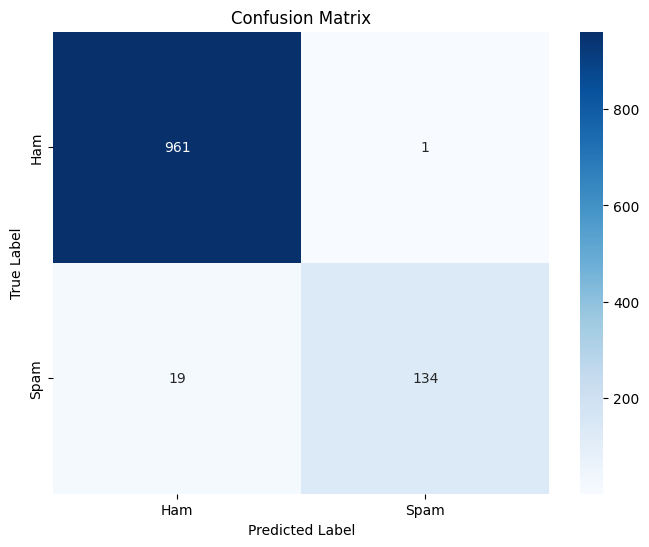

In [108]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()